# Evidence Transfer

In [1]:
import wandb

FOLDS = 20
wandb.init(project='evidence-transfer', config={
    'unet_loss': 'categorical_crossentropy',
    'connecting_unet_layer': 'expanding_block_64_conv2',
    'q_loss': 'binary_crossentropy',
    'q_lambda': 0.25,
    'optimizer': 'adam',
    'learning_rate': 1e-5,
    'momentum': None,
    'batch_size': 3,
    'dataset': f'folds{FOLDS}',
    'max_epochs': 100,
    'baseline_model': 'yjll7lns',
}, resume='allow')
hparams = wandb.config

wandb: Currently logged in as: vassilis_krikonis (use `wandb login --relogin` to force relogin)
/usr/local/lib/python3.6/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
from models.unet import create_unet
from models.evitram import create_evidence_transfer_model
import tensorflow as tf
import numpy as np

tf.random.set_seed(123)
np.random.seed(123)

unet = create_unet()
unet_weights = wandb.restore(
    'model-best.h5',
    run_path=f'vassilis_krikonis/unet-baseline/{hparams["baseline_model"]}'
)
unet.load_weights(unet_weights.name)

q_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid'),
], name='Q')

evitram = create_evidence_transfer_model(
    unet,
    q_model,
    'expanding_block_64_conv2',
    loss_lambda=hparams['q_lambda']
)

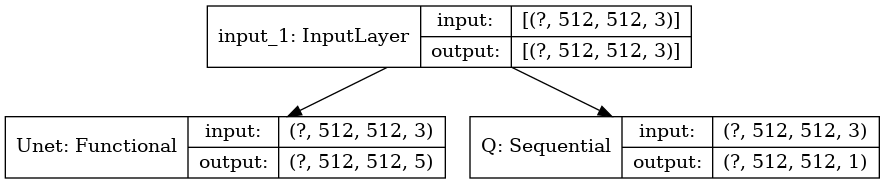

In [3]:
import tensorflow as tf

tf.keras.utils.plot_model(evitram, show_layer_names=True, show_shapes=True)

In [4]:
from metrics import CategoricalMeanIou
from tensorflow.keras.optimizers import SGD, Adam

if hparams['optimizer'] == 'sgd':
    optimizer = SGD(learning_rate=hparams['learning_rate'], momentum=hparams['momentum'])
elif hparams['optimizer'] == 'adam':
    optimizer = Adam(learning_rate=hparams['learning_rate'])
else:
    optimizer = hparams['optimizer']

evitram.compile(optimizer=optimizer, metrics=[
    [CategoricalMeanIou(num_classes=5), 'accuracy'],
    ['accuracy']
])

In [5]:
!mkdir -p /tmp/ds_cache/
from datasets.skyline12 import Skyline12

skyline12 = Skyline12('datasets/skyline12/data/')


def split_outputs(x, y, z):
    return x, (y, z)


train_ds = skyline12 \
    .as_tf_dataset(FOLDS, subset='training', cache_dir='/tmp/ds_cache/') \
    .map(split_outputs)
val_ds = skyline12 \
    .as_tf_dataset(FOLDS, subset='validation', cache_dir='/tmp/ds_cache/') \
    .map(split_outputs)

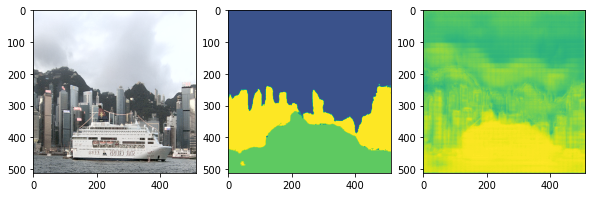

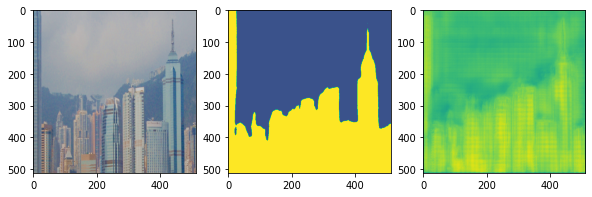

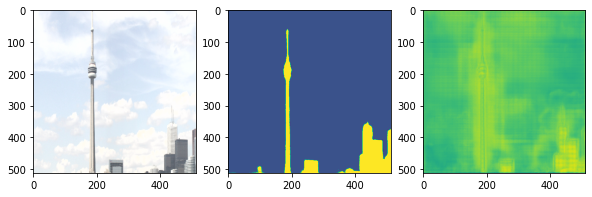

In [6]:
batch_x, _ = next(iter(val_ds.batch(3)))
preds = evitram(batch_x, training=False)

for x, y_pred, z_pred in zip(batch_x, *preds):
    Skyline12.show_sample(x, [y_pred, z_pred], from_tensors=True)

In [7]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.data.experimental import AUTOTUNE
from utils import get_new_logdir
from callbacks import LogEviTRAMImagesWandb
from wandb.keras import WandbCallback

log_dir = get_new_logdir(root_dir='./logs')
batch_size = hparams['batch_size']
if wandb.run.resumed:
    evitram.load_weights(wandb.restore('model-best.h5', replace=True).name)
evitram.fit(
    train_ds.batch(batch_size).prefetch(AUTOTUNE),
    epochs=hparams['max_epochs'],
    initial_epoch=wandb.run.step,
    validation_data=val_ds.batch(batch_size).prefetch(AUTOTUNE),
    callbacks=[
        EarlyStopping(patience=10),
        TensorBoard(
            log_dir=log_dir,
            histogram_freq=1,
        ),
        LogEviTRAMImagesWandb(next(iter(val_ds.batch(10)))),
        WandbCallback(save_weights_only=True)
    ]
)

Epoch 1/100
      1/Unknown - 0s 294us/step - loss: 0.7724 - Q_loss: 2.6404 - Unet_loss: 0.1123 - Unet_categorical_mean_iou: 0.5776 - Unet_accuracy: 0.9624 - Q_accuracy: 0.1482WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
800/800 [==============================] - 513s 642ms/step - loss: 0.1917 - Q_loss: 0.2426 - Unet_loss: 0.1311 - Unet_categorical_mean_iou: 0.7213 - Unet_accuracy: 0.9577 - Q_accuracy: 0.9105 - val_loss: 0.2798 - val_Q_loss: 0.2183 - val_Unet_loss: 0.2252 - val_Unet_categorical_mean_iou: 0.5677 - val_Unet_accuracy: 0.9546 - val_Q_accuracy: 0.9518
Epoch 2/100
800/800 [==============================] - 511s 639ms/step - loss: 0.1638 - Q_loss: 0.1561 - Unet_loss: 0.1247 - Unet_categorical_mean_iou: 0.7329 - Unet_accuracy: 0.9587 - Q_accuracy: 

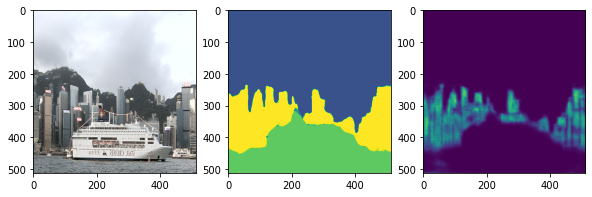

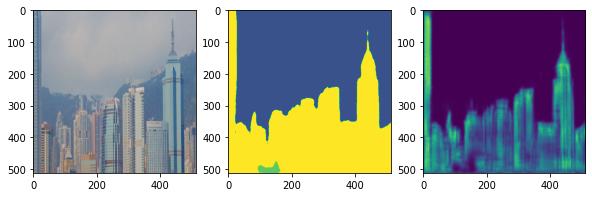

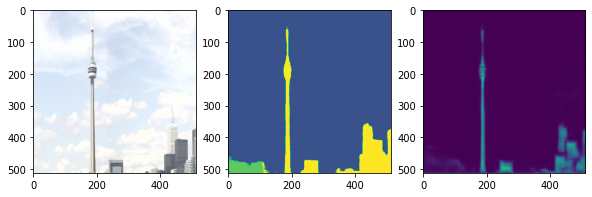

In [8]:
batch_x, _ = next(iter(val_ds.batch(3)))
preds = evitram(batch_x, training=False)

for x, y_pred, z_pred in zip(batch_x, *preds):
    Skyline12.show_sample(x, [y_pred, z_pred], from_tensors=True)

In [9]:
wandb.run.finish()

epoch,10
loss,0.09116
Q_loss,0.07969
Unet_loss,0.07124
Unet_categorical_mean_iou,0.74891
Unet_accuracy,0.96314
Q_accuracy,0.95261
val_loss,0.29327
val_Q_loss,0.26717
val_Unet_loss,0.22648
val_Unet_categorical_mean_iou,0.57378


epoch,▁▂▂▃▄▅▅▆▇▇█
loss,▅█▃▅▃▂▃▃▂▂▁
Q_loss,█▇▃▃▂▂▂▂▁▁▁
Unet_loss,▄█▃▅▃▂▃▃▂▂▁
Unet_categorical_mean_iou,▁▃▆▄▆▅▆▆▆█▇
Unet_accuracy,▁▂▄▃▄▅▅▆▅█▇
Q_accuracy,▁██████████
val_loss,▁█▁▂▁▁▃▁▂▂▁
val_Q_loss,▂▁▅█▇▇▇▆▆▇▇
val_Unet_loss,▁█▁▂▁▁▂▁▂▂▁
val_Unet_categorical_mean_iou,▅▁▆▄▆▆▅▆▆█▆
